In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.fftpack import fft
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

# Forecasting PJM Daily Energy Demand

PJM is a 'Regional Transmission Organizition' or RTO, and 'coordinates the movement of wholesale electricity in all or parts of 13 states'. See: http://www.pjm.com/

PJM is one of the more data-friendly grid operators. The purpose of this exercise is to explore time-series forecasting with PJM data. The data I downloaded from their website was 15-minute interval data.

Dataset found here: http://dataminer2.pjm.com/feed/hrl_load_metered/definition. Go to 'Explore data', then inside the pop-up select the data range of interest.
This is a manual workaround while I do not have access to an api. The largest available date range we could pull is 11/1/2016 - current. 

load the data...

In [2]:
df = pd.read_csv('hrl_load_metered (2).csv') #1 year worth of PJM data, woah!!

In [3]:
df.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,11/1/2016 4:00:00 AM,11/1/2016 12:00:00 AM,RFC,MIDATL,AE,AE,849.077,True
1,11/1/2016 4:00:00 AM,11/1/2016 12:00:00 AM,OTHER,OTHER,OTHER,AECO,849.077,True
2,11/1/2016 4:00:00 AM,11/1/2016 12:00:00 AM,RFC,WEST,AEP,AEPAPT,3371.310,True
3,11/1/2016 4:00:00 AM,11/1/2016 12:00:00 AM,RFC,WEST,AEP,AEPIMP,2560.009,True
4,11/1/2016 4:00:00 AM,11/1/2016 12:00:00 AM,RFC,WEST,AEP,AEPKPT,513.897,True


In [4]:
df.load_area.unique()

array(['AE', 'AECO', 'AEPAPT', 'AEPIMP', 'AEPKPT', 'AEPOPT', 'AP', 'BC',
       'CE', 'DAY', 'DEOK', 'DOM', 'DPLCO', 'DUQ', 'EASTON', 'EKPC', 'JC',
       'ME', 'OE', 'PAPWR', 'PE', 'PEPCO', 'PLCO', 'PN', 'PS', 'RECO',
       'SMECO', 'UGI', 'RTO', 'VMEU'], dtype=object)

Focusing on PEPCO for no particular reason. I'm pretty sure stands for 'Potomac Electric Power Company'
See: https://www.pepco.com/

## Exploring PJM PEPCO data

In [5]:
df_pepco = df[df.load_area=='PEPCO'].reset_index(drop=True)

In [6]:
len(df_pepco)

9265

Confirming 8760 data (number of hours in a full year). Data slightly longer than 1 year.<br>
Check for null values (there are none but just check anyway)

In [7]:
df_pepco.head(2)

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,11/1/2016 4:00:00 AM,11/1/2016 12:00:00 AM,RFC,MIDATL,PEP,PEPCO,2161.229,True
1,11/1/2016 5:00:00 AM,11/1/2016 1:00:00 AM,RFC,MIDATL,PEP,PEPCO,2072.248,True


In [8]:
df_pepco.tail(2)

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
9263,11/22/2017 3:00:00 AM,11/21/2017 10:00:00 PM,RFC,MIDATL,PEP,PEPCO,2500.761,False
9264,11/22/2017 4:00:00 AM,11/21/2017 11:00:00 PM,RFC,MIDATL,PEP,PEPCO,2348.153,False


Turning the date-time stirngs into datetime

In [9]:
df_pepco.mw.describe()

count    9265.000000
mean     2952.843078
std       610.911937
min      1862.649000
25%      2527.855000
50%      2874.353000
75%      3251.465000
max      5363.152000
Name: mw, dtype: float64

In [10]:
df_pepco['dt'] = [datetime.strptime(i,'%m/%d/%Y %I:%M:%S %p') for i in df_pepco.datetime_beginning_utc]

### Visualizing Raw Data

Times are UTC, Looking at 1 day...

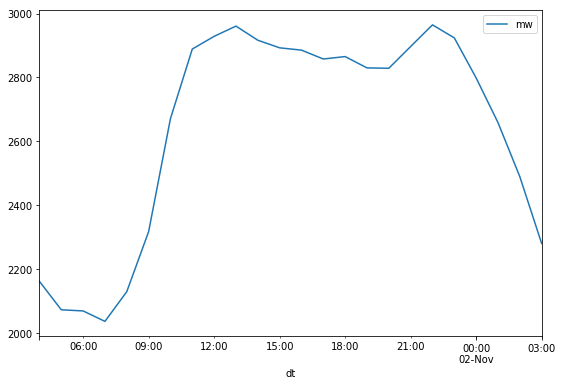

In [11]:
df_pepco[0:24].plot(x='dt',y='mw',figsize=(9,6))

About 1 month...

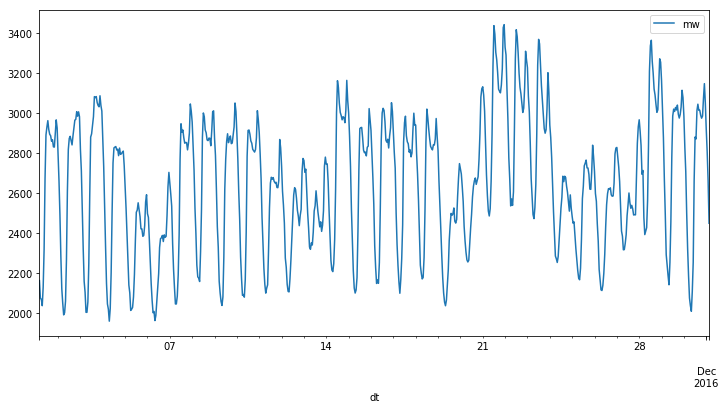

In [12]:
df_pepco[0:720].plot(x='dt',y='mw',figsize=(12,6))

Makes sense. Suspect that load is higher on weekdays (Monday-Friday) and lower on weekeends (Saturday, Sunday). We can use a box plot to help visualize this..

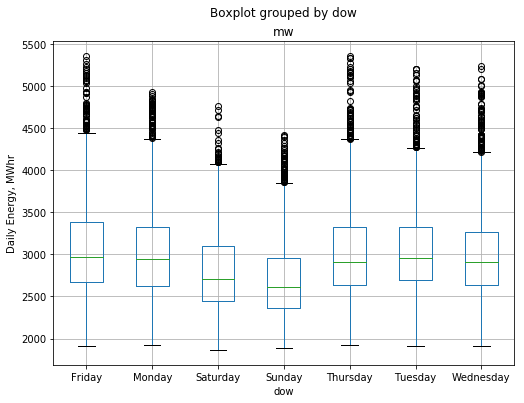

In [13]:
day_map = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
df_pepco['dow'] = [day_map[i.dayofweek] for i in df_pepco['dt']]
fig,ax = plt.subplots(figsize=(8,6))
df_pepco.boxplot(column='mw',by='dow',ax=ax)
ax.set_ylabel('Daily Energy, MWhr');

Can see strong weekly seasonality. Full dataset (just over 1 year)...

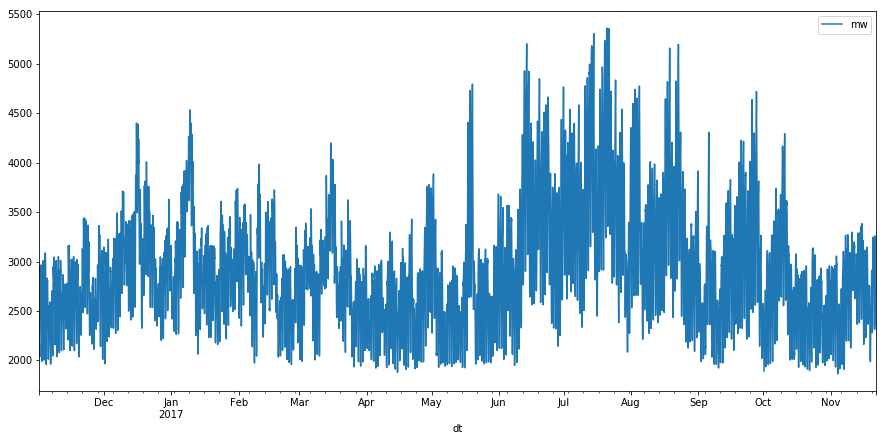

In [14]:
df_pepco.plot(x='dt',y='mw',figsize=(15,7))

There is a *ton* of variation in this data. Given that this is a first cut forecast, I'm going to sum the hourly power values into energy. The timedelta for each data point in our timeseries is 1 hour, and we have avergage MW values for the period. Therefore, each value is both an average power value ($\bar{MW}$) and an energy value, $MWh$. <br>

Note: this assumes the avg. hourly power value is an accurate representation of the power flow during the time interval. Typically interval data consists of power values averaged over 15-minute periods (as opposed to 1 hour), so our resolution here isn't great.

In [15]:
df_resamp = df_pepco.set_index('dt',drop=True).resample('D').sum() #total daily energy

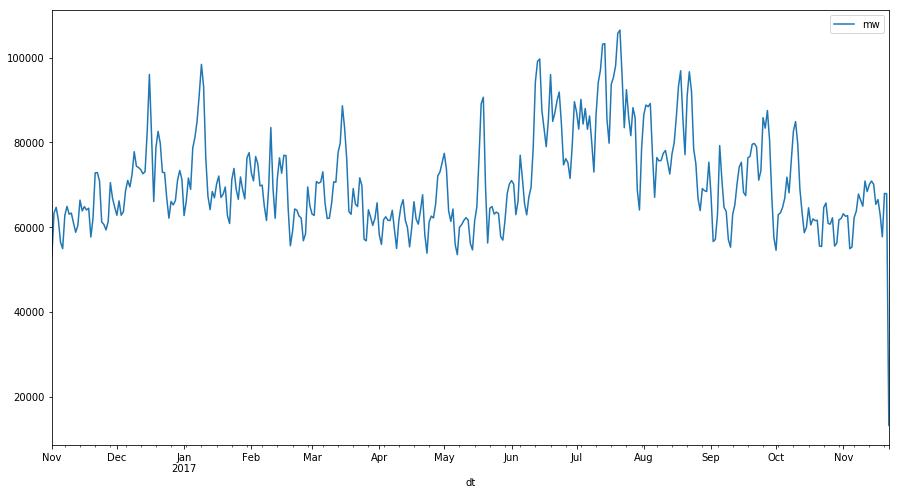

In [16]:
df_resamp.plot(use_index=True,y='mw',figsize=(15,8))

Out of curiosity, how does the energy consumption compare per month

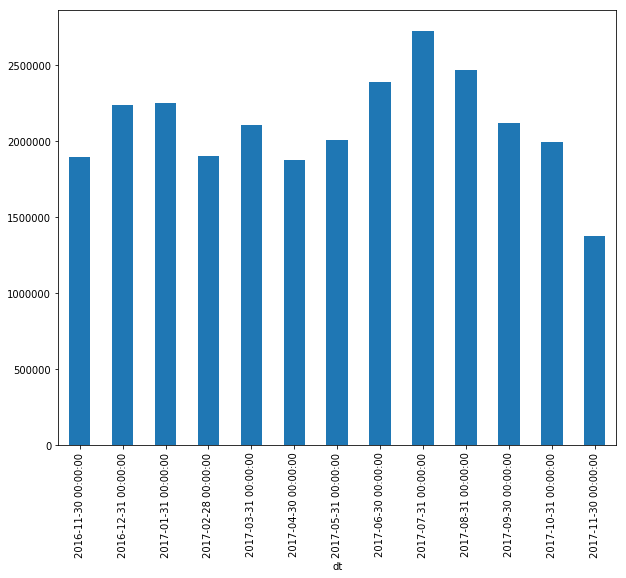

In [17]:
df_pepco.set_index('dt',drop=True).resample('1m').mw.sum().plot(kind='bar',figsize=(10,8)) #monthly sum

## Time Series Forecast

Method here will be to forecast the some of the data in our PJM PEPCO dataset. Using the following resources as a guide:
* http://www.saedsayad.com/docs/Time%20Series%20and%20Forecasting.pdf
* https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c
* https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

Some of my conerns at the outset are that the dataset contains a lot of variation when looking at the hourly data. I'm not sure if the model will be able to handle this, we'll see. I have have to resample the data by H > D > W > M and check the results.

### Stationary data

In order build a time series model, we must first ensure the data is stationary. We must do this because the statistical models used (i.e. regression) employs a fundamental assumption that the underlying data is made of independent random variables. Now we know our dataset is time-dependent, however stationary random data can be used in place.

To qualify as a 'stationary' series, a set of data must obey the following:
1. Trend: The mean of the series must not be a function of time. You can tell if the mean is a function of time with a simple visualization of your data - if you notice a clear upward or downward trend, the dataset is not stationary.
2. Homoscedasticity: The variance of the series must not be a function of time. 
3. Covariance: The measure by which two variables vary (or move) together. 

Excellent depiction of the assumptions above found here: http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/ <br>

In our application, we're on the look-out and will aim to resolve two main criteria:

1. Trend: upward (or downward) changes to mean energy demand over time
2. Seasonality: periodic changes to energy demand in specific time-intervals. One pretty obvious hpyothesis here is that we'll see clear 'seasonality' on a 7-day basis, with high energy demand during the weekdays, lower during the weekend, and repeat.

First, I'm going toremove the Nov 2017 values from the timeseries data. I will use the bulk data to build the model and try to forecast the mean daily power values for the excluded values: 11/1/2017 - 11/22/2017 (didn't actually do this...)

In [18]:
df_resample = df_resamp.mw[0:-1] # the last day is not a full days worth of data

In [19]:
train = df_resample[0:-20]
test = df_resample[-20:]

To evaulate whether our dataset if stationary, we can employ a visual check and the Dicky-Fuller test (https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)<br>

In [20]:
def stationary_check(tsdata):
    fig,ax = plt.subplots(2,1,figsize=(13,6),sharex=True)
    ax[0].plot(tsdata,'y',label='hourly power data');
    ax[0].plot(pd.rolling_mean(tsdata,window=int(len(tsdata)/50),center=False),'k',label='rolling mean');
    ax[0].legend()
    ax[1].plot(pd.rolling_std(tsdata,window=int(len(tsdata)/50),center=False),'b',label='rolling standard deviation');
    ax[1].legend()
    dicky_fuller = adfuller(tsdata, autolag='AIC')
    dicky_fuller_res = pd.Series(dicky_fuller[0:4],
                             index=['t-statistic','p-value','num of lags','num of observations'])
    for k,v in dicky_fuller[4].items():
        dicky_fuller_res['critical value: {0}'.format(k)] = v
    return dicky_fuller_res, plt

t-statistic             -2.309476
p-value                  0.168930
num of lags             15.000000
num of observations    350.000000
critical value: 5%      -2.869833
critical value: 1%      -3.449173
critical value: 10%     -2.571188
dtype: float64


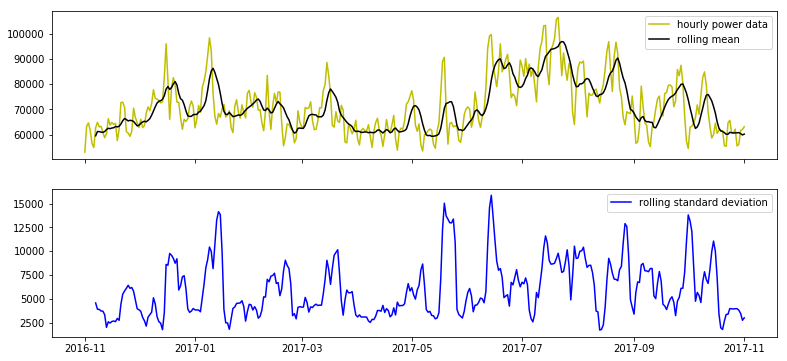

In [21]:
df, f = stationary_check(train)
print (df)

The timeseries data *is not* stationary:
* visual check fails, mean varies, deviation time dependant
* p-value > 0.05
* t-statistic > critical value at 1%

Comment on this data - we need to make this data stationary.

### Perform a log transform on the timeseries data 

Comment on why we perform a log transform and what that helps remove

t-statistic             -2.276007
p-value                  0.179823
num of lags             15.000000
num of observations    350.000000
critical value: 5%      -2.869833
critical value: 1%      -3.449173
critical value: 10%     -2.571188
dtype: float64


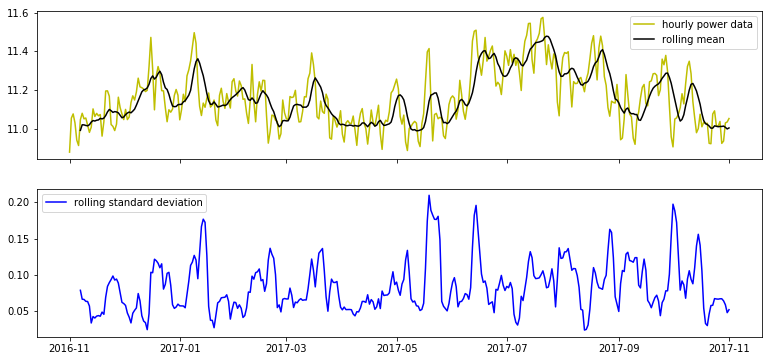

In [22]:
train_log = np.log(train)
df, f = stationary_check(train_log)
print (df)

The timeseries data still not stationary:
* p-value > 0.05
* t-statistic > critical value at 1%

Comment on this data.<br>

Next step is to try to eliminate the trend and seasonality of the dataset. We can use the *seasonal_decompose* package from the *statsmodel* library for this:

### Option A - eliminate trend and seasonality using decomposition

In [23]:
decomp = seasonal_decompose(train_log,model='additive')

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

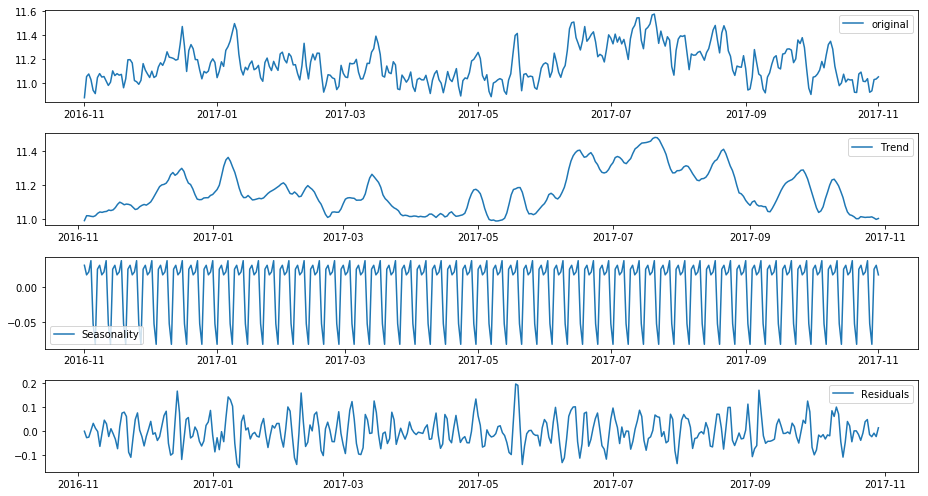

In [24]:
fig,ax = plt.subplots(4,1,figsize=(13,7))
ax[0].plot(train_log.index, train_log.values,label='original')
ax[0].legend()
ax[1].plot(train_log.index, trend.values, label='Trend')
ax[1].legend()
ax[2].plot(train_log.index, seasonal.values,label='Seasonality')
ax[2].legend()
ax[3].plot(train_log.index, residual.values, label='Residuals')
ax[3].legend()
plt.tight_layout()

Notes on trend: definitely see overall increased energy usage duringt the summer time. There are spikes throughout the year (releative to a low baseline in the spring around April). I would guess these are either weather or holiday related, where holidays. <br>

Notes on seasonality: crystal clear seasonality every 7 days (weekly).

The decomp function removes trend and seasonality, leaving us with the residual to model:

t-statistic           -8.502567e+00
p-value                1.227040e-13
num of lags            1.700000e+01
num of observations    3.420000e+02
critical value: 5%    -2.870028e+00
critical value: 1%    -3.449616e+00
critical value: 10%   -2.571292e+00
dtype: float64


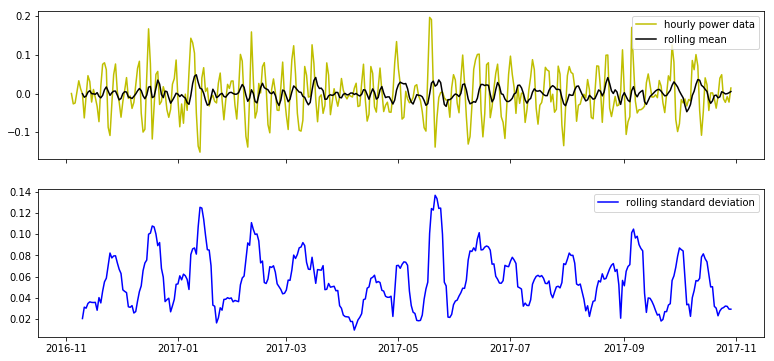

In [25]:
train_log_decomp = residual
train_log_decomp.dropna(inplace=True)
df, f = stationary_check(train_log_decomp)
print (df)

From the Dickey–Fuller test, we now have a stationary timeseries dataset. Our t-statistic is well below the critical value and our p-value is well below 0.05. 

Good outline on what the decomp does here: http://www.cbcity.de/timeseries-decomposition-in-python-with-statsmodels-and-pandas

### Option B - Difference the data to remove trend and seasonality

Another very common and effective way to elimiante seasonality and trend is by differencing. Good documentation here: https://machinelearningmastery.com/difference-time-series-dataset-python/. Pandas has a convient function *shift* that allows us to perform this simply. This differencing technique will subtract the previous energy value from the subsequent value in the series ($E_d = E_1 - E_0$)

t-statistic           -7.413834e+00
p-value                7.019702e-11
num of lags            1.400000e+01
num of observations    3.500000e+02
critical value: 5%    -2.869833e+00
critical value: 1%    -3.449173e+00
critical value: 10%   -2.571188e+00
dtype: float64


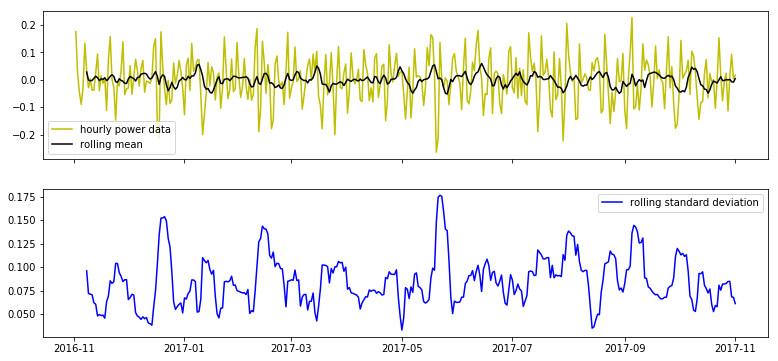

In [26]:
train_log_diff = train_log - train_log.shift()
train_log_diff.dropna(inplace=True)
df,f = stationary_check(train_log_diff)
print (df)

We can confidently say our timeseries data is stationary. Our p-value is well below the 0.05 alpha value and the t-statistics is well below the critical 1% value

## Autoregressive Integrated Moving Average (ARIMA)

Using the ARIMA model on the stationary time series data.

The ARIMA model needs three parameters:

1. p: the autoregression (AR) term. This is the number of 'lag' terms, or how many previous variables will be used to predict the current value.
2. q: the moving-averge (MA) term. This is the number of 'lag' error terms, or how many previous error terms will be used to predict the current value. The error term is the difference between the moving average value and the actual value at each given time.
3. d: the difference term. This is the number of non-seasonal differences. In the case above, we took a first order difference so our d will be 1. 

Here are some excellent resources:
* understanding how everything fits together: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
* understanding the ARIMA model: https://people.duke.edu/~rnau/411arim.htm 
* understanding the difference term: https://people.duke.edu/~rnau/411diff.htm

Now, in order to find the best *p* and *q* parameters for the ARIMA model, we can use the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to help guide our decision.

Good resource on ACF and PACF:
* https://onlinecourses.science.psu.edu/stat510/node/64

In [27]:
lag_acf = acf(train_log_diff, nlags=40)
lag_pacf = pacf(train_log_diff, nlags=40, method='ols')

In [28]:
def plot_cf(acf,pacf):
    fig,ax = plt.subplots(1,2,figsize=(15,6))
    ax[0].plot(acf,'-o',label='ACF')
    ax[0].axhline(y=0,linestyle='--',color='gray')
    ax[0].axhline(y=-1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
    ax[0].axhline(y=1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
    ax[0].legend()
    ax[1].plot(pacf,'-o',label='PACF')
    ax[1].axhline(y=0,linestyle='--',color='gray')
    ax[1].axhline(y=-1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
    ax[1].axhline(y=1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
    ax[1].legend()
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

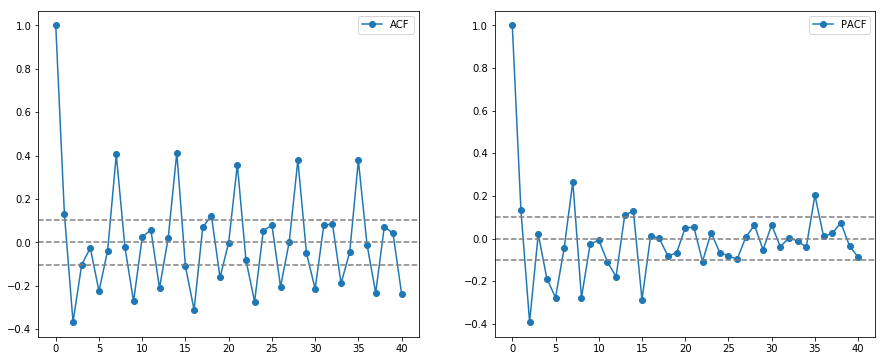

In [29]:
plot_cf(lag_acf,lag_pacf)

Another (easier) way to view the ACF and PACF:

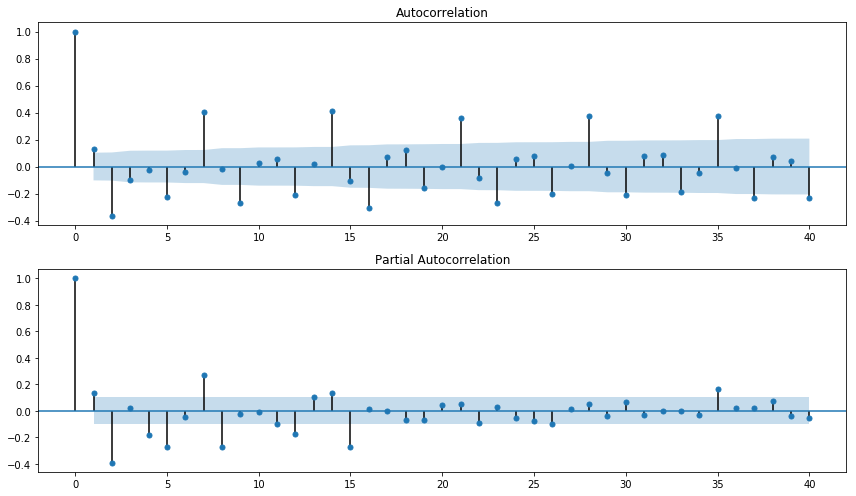

In [30]:
fig, ax = plt.subplots(2,1,figsize=(12,7))
plot_acf(train_log_diff, lags=40,ax=ax[0]);
plot_pacf(train_log_diff, lags=40,ax=ax[1]);
plt.tight_layout()

We still have very high autocorrelation at high number of lags (outside the confidence interval ~40 lags..). To resolve this we can try to take another higher order difference.

<b> One order difference *along* on the timeseries will not be enough to resolve the seasonality and trend components on the data, despite passing the dicky-fuller test.</b>
    
### Experimenting with ACF and PACF

Below I try to increaes the order of differencing, and combine the decomposition component. Starting first with a second order difference:

t-statistic           -9.006457e+00
p-value                6.292507e-15
num of lags            1.500000e+01
num of observations    3.480000e+02
critical value: 5%    -2.869881e+00
critical value: 1%    -3.449282e+00
critical value: 10%   -2.571214e+00
dtype: float64


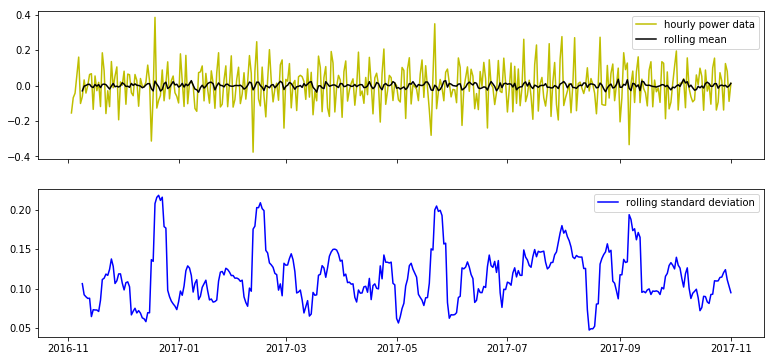

In [31]:
train_log_diff2 = train_log_diff - train_log_diff.shift()
train_log_diff2.dropna(inplace=True)
df,f = stationary_check(train_log_diff2)
print (df)

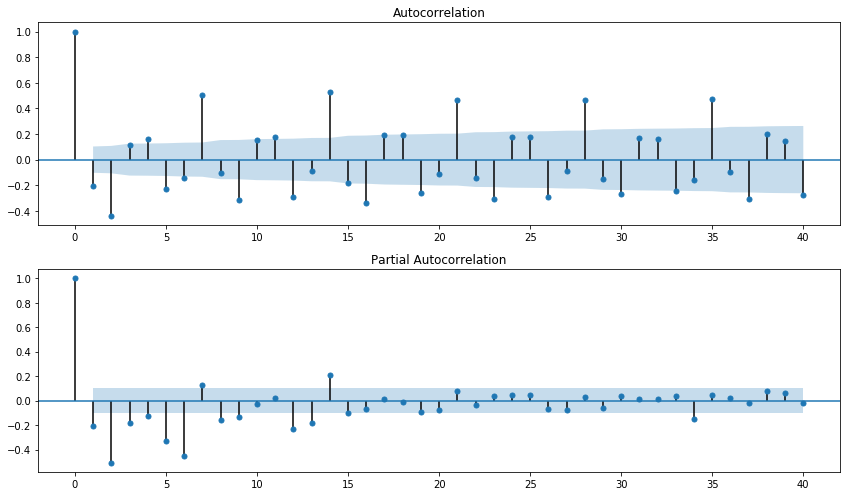

In [32]:
fig, ax = plt.subplots(2,1,figsize=(12,7))
plot_acf(train_log_diff2, lags=40,ax=ax[0]);
plot_pacf(train_log_diff2, lags=40,ax=ax[1]);
plt.tight_layout()

Still seeing AC outside the confidence bounds. Let's try a third order difference...

t-statistic           -1.081738e+01
p-value                1.842462e-19
num of lags            1.600000e+01
num of observations    3.460000e+02
critical value: 5%    -2.869930e+00
critical value: 1%    -3.449392e+00
critical value: 10%   -2.571240e+00
dtype: float64


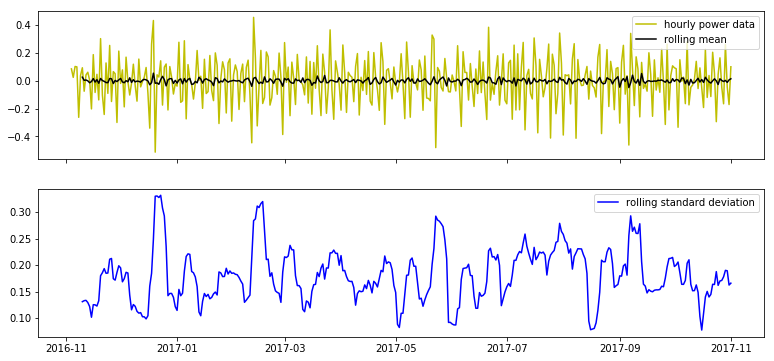

In [33]:
train_log_diff3 = train_log_diff2 - train_log_diff2.shift()
train_log_diff3.dropna(inplace=True)
df,f = stationary_check(train_log_diff3)
print (df)

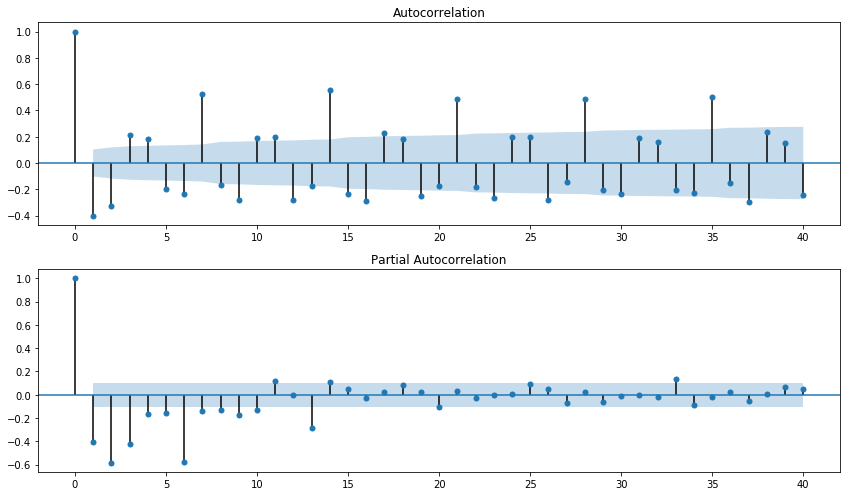

In [35]:
fig, ax = plt.subplots(2,1,figsize=(12,7))
plot_acf(train_log_diff3, lags=40,ax=ax[0]);
plot_pacf(train_log_diff3, lags=40,ax=ax[1]);
plt.tight_layout()

Still no improvement, actually looks like it may be getting worse. Let's try plotting ACF and PACF on the decomposition timeseries:

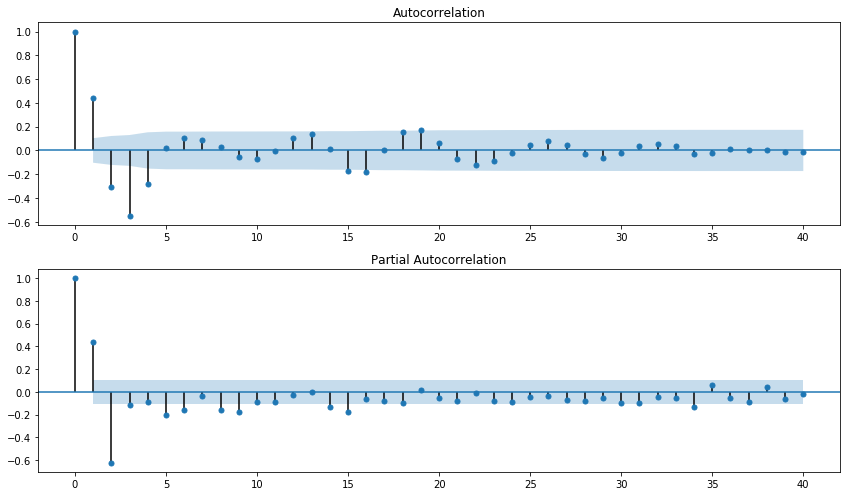

In [39]:
fig, ax = plt.subplots(2,1,figsize=(12,7))
plot_acf(train_log_decomp, lags=40,ax=ax[0]);
plot_pacf(train_log_decomp, lags=40,ax=ax[1]);
plt.tight_layout()

Looks promising, let's try taking a difference on the decompositioned data:

t-statistic           -1.019795e+01
p-value                6.076134e-18
num of lags            1.700000e+01
num of observations    3.410000e+02
critical value: 5%    -2.870053e+00
critical value: 1%    -3.449673e+00
critical value: 10%   -2.571306e+00
dtype: float64


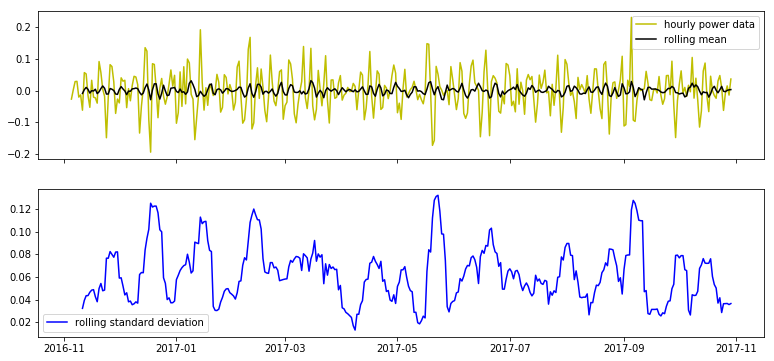

In [40]:
train_log_decomp_diff = train_log_decomp - train_log_decomp.shift()
train_log_decomp_diff.dropna(inplace=True)
df,f = stationary_check(train_log_decomp_diff)
print (df)

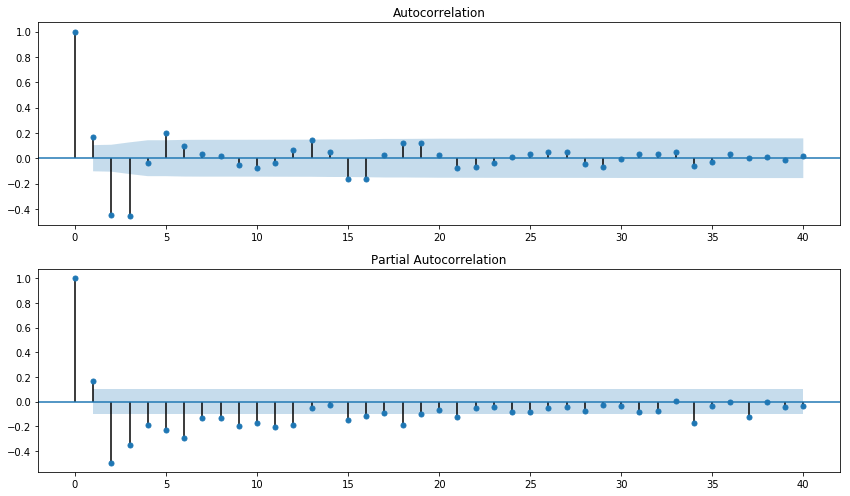

In [62]:
fig, ax = plt.subplots(2,1,figsize=(12,7))
plot_acf(train_log_decomp_diff, lags=40,ax=ax[0]);
plot_pacf(train_log_decomp_diff, lags=40,ax=ax[1]);
plt.tight_layout()

Looks like only a minor improvement over the regular decomposition (without differencing). I'll put the decomped data (non-differenced) into the arima model below.

We can use the '_arima_order_select_ic_' function to help find the optimal parameters for our model

In [42]:
res = arma_order_select_ic(train_log_decomp, ic=['aic', 'bic'])
print (res.aic_min_order)
print (res.bic_min_order)

(4, 1)
(3, 1)


The ARIMA model takes three parameters: p, d, and q. See description of these parameters here: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ 
<br><br>We will use p = 4, q = 3 and d = 0 

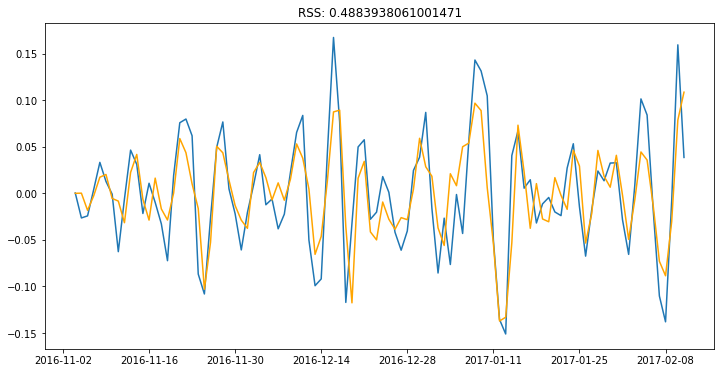

In [46]:
model = ARIMA(train_log_decomp, order=(4, 0, 3))  
results_ARIMA = model.fit(disp=0)
fig,ax=plt.subplots(figsize=(12,6))
ax.plot(train_log_decomp[0:100])
ax.plot(results_ARIMA.fittedvalues[0:100], color='orange')
ax.set_title('RSS: {0}'.format(sum((results_ARIMA.fittedvalues - train_log_decomp).dropna()**2)));

                0
count  360.000000
mean    -0.000032
std      0.036884
min     -0.098663
25%     -0.021791
50%     -0.001605
75%      0.021788
max      0.135532


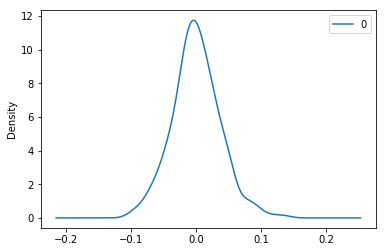

In [48]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

Need to add back the trend and seasonal components of the data. Recall we modelled on the residual of the decomp after isolating the trend and seasonality components. Let's see if this works..

In [49]:
p_decomp = pd.Series(results_ARIMA.fittedvalues).copy()
p_log = p_decomp + trend + seasonal.values
p_act = np.exp(p_log)

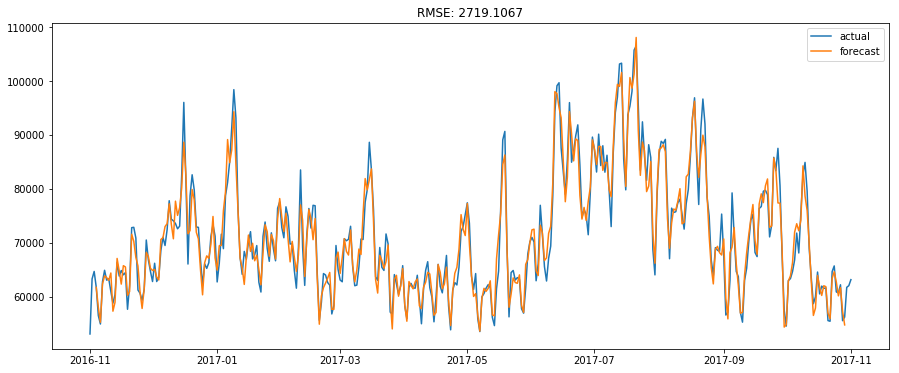

In [50]:
fig,ax = plt.subplots(figsize=(15,6))
ax.plot(train.index, train.values, label='actual')
ax.plot(train.index, p_act.values,label='forecast')
ax.set_title('RMSE: %.4f'% np.sqrt(sum((p_act-train).dropna()**2)/len(train)));
ax.legend()

Overvall, the ARIMA model appears to fit our PJM PEPCO daily energy curve nicely. Let's zoom in on the last 50 days:

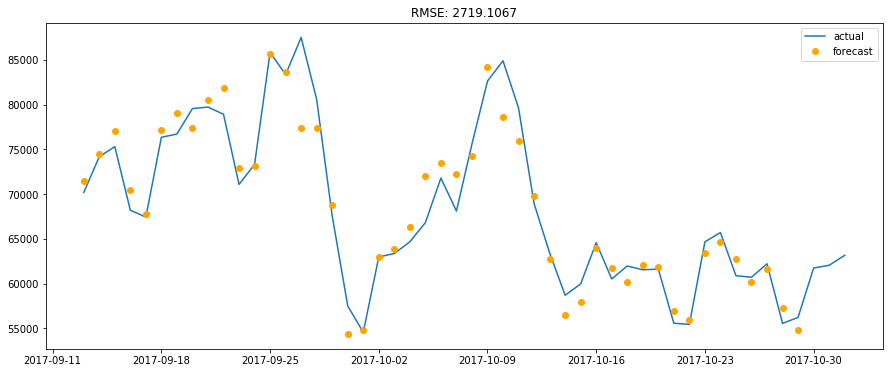

In [51]:
fig,ax = plt.subplots(figsize=(15,6))
ax.plot(train.index[-50:], train.values[-50:], label='actual')
ax.plot(train.index[-50:], p_act.values[-50:], 'o',c='orange', label='forecast')
ax.set_title('RMSE: %.4f'% np.sqrt(sum((p_act-train).dropna()**2)/len(train)));
ax.legend()

Recall, we only fit the model on the train dataset and actually removed November 2017 data. We could use the _predict_ function to see how closely our ARIMA model predicts the actual daily energy values, however given our approach we have an issue. Using the decomposition method, we would need a forecast for trend and seasonality to add back to the model's prediction! 

Creating a forecast for the trend:

In [112]:
res = arma_order_select_ic(trend.values[~np.isnan(trend.values)], ic=['aic', 'bic'])
print (res.aic_min_order)
print (res.bic_min_order)

(4, 2)
(4, 2)


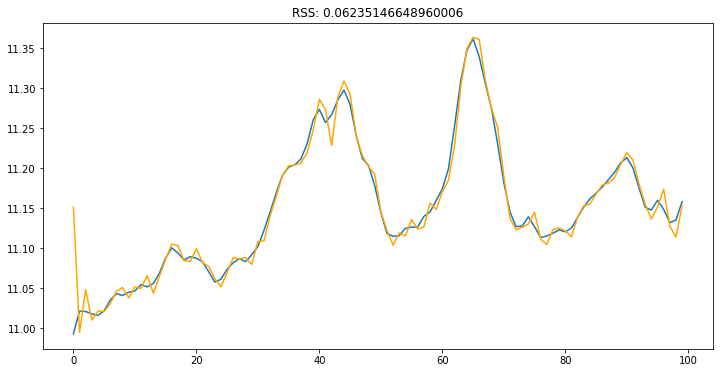

In [113]:
model = ARIMA(trend.values[~np.isnan(trend.values)], order=(4, 0, 4))  
results_ARIMA = model.fit(disp=3)
fig,ax=plt.subplots(figsize=(12,6))
ax.plot(trend.values[3:103])
ax.plot(results_ARIMA.fittedvalues[0:100], color='orange')
ax.set_title('RSS: {0}'.format(sum((results_ARIMA.fittedvalues - trend.values[3:-3])**2)));

Now extending the entire trend series using the forecast. The _forecast_ function gives the next period forecast (so in our case 1 day). Once we have this value we'll append it to the original trend set and re-run the arima model

In [289]:
extend_decomp = 23
t_vals = list(trend.values[~np.isnan(trend.values)])
for i in range(0,extend_decomp):
    model = ARIMA(t_vals, order=(4, 0, 4))  
    results_ARIMA = model.fit()
    fcast = results_ARIMA.forecast()[0]
    t_vals.append(fcast[0])
t_vals = [0,0,0] + t_vals #need to append zeros to the front in place of nans that are missing

Found a good arima fit at p=5, q=3 for the seasonal compnent. The set looks almost perfectly seasonal with a 7 day period, we could show this probably with a FFT

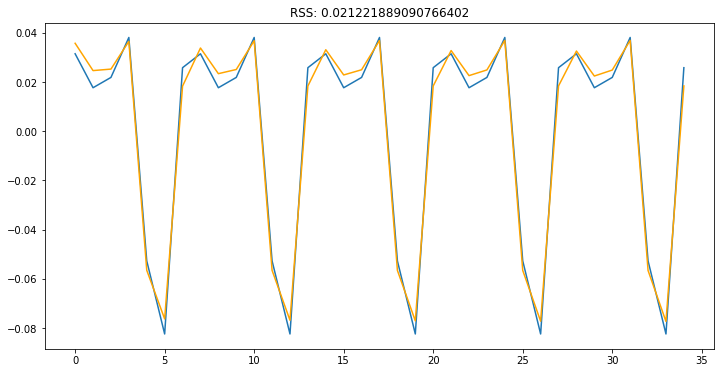

In [196]:
model = ARIMA(seasonal.values[~np.isnan(seasonal.values)], order=(5, 0, 3))  
results_ARIMA = model.fit(disp=3)
fig,ax=plt.subplots(figsize=(12,6))
ax.plot(seasonal.values[~np.isnan(seasonal.values)][14:49])
ax.plot(results_ARIMA.fittedvalues[14:49], color='orange')
ax.set_title('RSS: {0}'.format(sum((results_ARIMA.fittedvalues - seasonal.values)**2)));

In [197]:
extend_decomp = 20 #add 20 more values to our seasonal parameter
s_vals = list(seasonal.values)
for i in range(len(s_vals),len(s_vals)+extend_decomp):
    s_vals.append(s_vals[i-7])

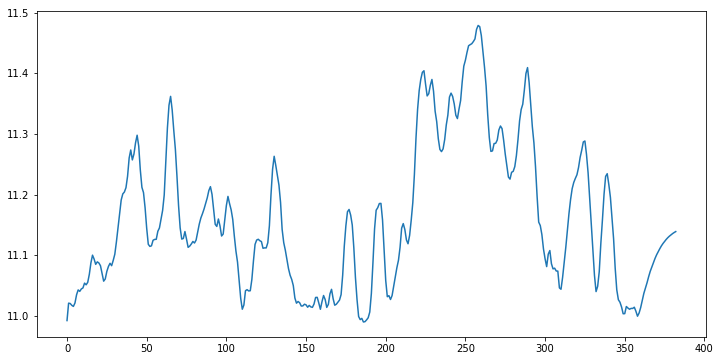

In [390]:
fig,ax=plt.subplots(figsize=(12,6))
ax.plot(t_vals[3:])
#ax.plot(results_ARIMA.fittedvalues[14:49], color='orange')
#ax.set_title('RSS: {0}'.format(sum((results_ARIMA.fittedvalues - seasonal.values)**2)));

Now I have the forecasted decomp values I can try to put together a forecast for November

special note:<br>
the trend set had nan values at from 0:3 and -3:<br>
the seaonsal set had values for the full set<br>
the forecast also had nan values from 0:3 and -3:<br>
when aligning the data, need to make sure to add the correct value

In [382]:
model = ARIMA(train_log_decomp, order=(4, 0, 3))  
results_ARIMA = model.fit()
p_decomp = pd.Series(results_ARIMA.fittedvalues).copy()
p_log = p_decomp + t_vals[3:-23] + s_vals[3:-23]
p_act = np.exp(p_log)
resid_values = list(train_log_decomp.values)
model_data = list(p_act.values)
forecast_dates = list(p_act.index.values)
forecast_values = []
ci_minus = []
ci_plus = []

In [383]:
for i in range(len(p_act),len(p_act)+extend_decomp):
    print (i)
    model = ARIMA(resid_values, order=(4, 0, 3))
    results_ARIMA = model.fit()
    fcast = results_ARIMA.forecast()[0]
    resid_values.append(fcast[0])
    forecast_values.append(np.exp(fcast[0] + s_vals[i] + t_vals[i]))
    model_data.append(np.exp(fcast[0] + s_vals[i] + t_vals[i]))
    forecast_dates.append(forecast_dates[i-1] + np.timedelta64(1,'D'))
    ci_minus.append(np.exp(results_ARIMA.forecast()[2][0][0] + s_vals[i] + t_vals[i]))
    ci_plus.append(np.exp(results_ARIMA.forecast()[2][0][1] + + s_vals[i] + t_vals[i]))

360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382


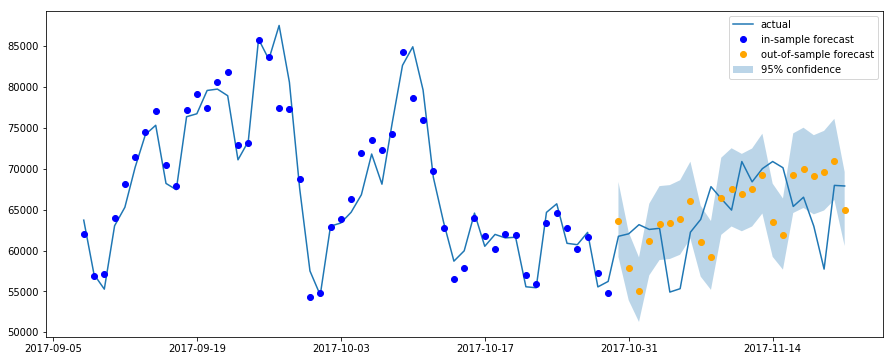

In [385]:
fig,ax = plt.subplots(figsize=(15,6))
ax.plot(df_resample.index[-75:], df_resample.values[-75:], label='actual') #actual data
ax.plot(forecast_dates[-75:-len(forecast_values)], model_data[-75:-len(forecast_values)], 'o',c='blue', label='in-sample forecast')
ax.plot(forecast_dates[-len(forecast_values):], forecast_values, 'o',c='orange', label='out-of-sample forecast')
ax.fill_between(pd.to_datetime(forecast_dates)[-len(ci_minus):], ci_minus, ci_plus,alpha=0.3,label='95% confidence')
#ax.set_title('RMSE: %.4f'% np.sqrt(sum((forecast_values-df_resample.values)**2)/len(df_resample.values)));
ax.legend()